# Gaussian Processes (GP)

In this notebook we will learn how to use <a href="http://sheffieldml.github.io/GPy/">GPy</a> library to deal with gaussian processes. This library provide quite simple and inuitive interfaces for training and inference, and we will try to get familiar with them in a few tasks.

### Setup:

Load auxiliary files and then install and import the necessary libraries.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    ! pip install GPy

In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Gaussian processes: GPy (<a href="http://sheffieldml.github.io/GPy/">documentation</a>)

We will start with a simple regression problem, for which we will try to fit a Gaussian Process with RBF kernel.


In [2]:
def generate_points(n=25, noise_variance=0.0036):
    #np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y
    
def generate_noise(n=25, noise_variance=0.0036):
    #np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.random.randn(n, 1) * noise_variance**0.5
    return X, y

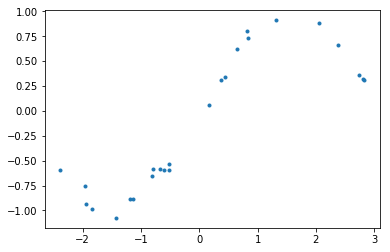

In [3]:
# Create data points
X, y = generate_points()
plt.plot(X, y, '.')
plt.show()

To fit a Gaussian Process, we will need to define a kernel. For Gaussian (GBF) kernel we can use `GPy.kern.RBF` function.

Let's create a RBF kernel with variance 1.5 and length-scale parameter 2 for 1D samples:


In [4]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

Now we can fit GP into generated data using the `GPy.models.GPRegression` class.

In [5]:
model = GPy.models.GPRegression(X,y,kernel)

Now we can plot the model predictions:

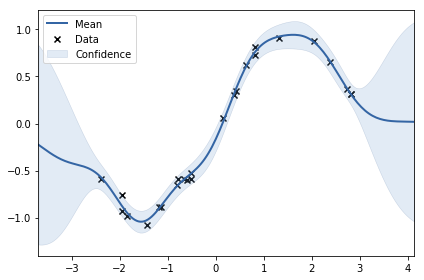

In [9]:
model.plot()
plt.show()

We see that the model didn't fit the data quite well. Let's try to fit kernel and noise parameters automatically as discussed in the lecture! You can see the current parameters below:

In [10]:
model

GP_regression.,value,constraints,priors
rbf.variance,0.3345194858423545,+ve,
rbf.lengthscale,0.7499695124992334,+ve,
Gaussian_noise.variance,0.0024209860361517365,+ve,


Let's optimize the length-scale, variance and noise component of the model:

In [8]:
model.optimize_restarts(num_restarts=20, verbose=False)
length = model.rbf.lengthscale.data[0]
variance = model.rbf.variance.data[0]
noise = model.Gaussian_noise.variance.data[0]
print('fitted parameters: length = %2.2f, variance = %2.2f, noise = %2.2f'% (length,variance,noise))

fitted parameters: length = 0.75, variance = 0.33, noise = 0.00


In [ ]:
model

In [ ]:
x = np.atleast_2d(np.linspace(-4, 4, 200)).T
plt.rcParams['figure.figsize'] = 10, 10
#model.plot(plot_density=False) # set density to True for density plot
y_pred, variance = model.predict(x)
sigma = np.sqrt(variance)
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x,np.sin(x),'k:',linewidth=4, label=r'$f(x) = \sin(x)$')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                          (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')       
plt.legend()
plt.show()

As we can see, the process generates outputs just right. Let's see if GP can figure out itself when we try to fit it into noise or signal.

Generate two datasets: sinusoid wihout noise and samples from gaussian noise. Optimize kernel parameters and submit optimal values of noise component. Generate data only using ```generate_points(n, noise_variance)``` and ```generate_noise(n, noise_variance)``` function!

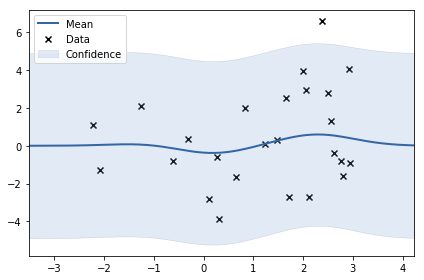

GP_regression.,value,constraints,priors
rbf.variance,0.4158146414601517,+ve,
rbf.lengthscale,0.7101721219370737,+ve,
Gaussian_noise.variance,5.802893682484842,+ve,


In [11]:
X, y = generate_noise(noise_variance=10)
noise = GPy.models.GPRegression(X,y,kernel)
noise.optimize()
noise.plot(plot_density=False) # set density to True for density plot
plt.show()
noise

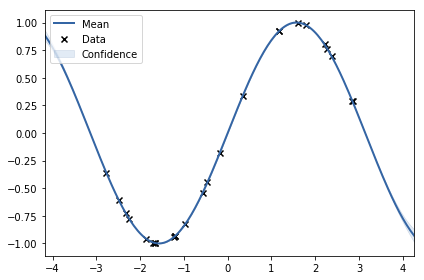

GP_regression.,value,constraints,priors
rbf.variance,3.6837139043071403,+ve,
rbf.lengthscale,2.614045854312484,+ve,
Gaussian_noise.variance,3.1794675994611805e-16,+ve,


In [12]:
X, y = generate_points(noise_variance=0)
signal = GPy.models.GPRegression(X,y,kernel)
signal.optimize()
signal.plot(plot_density=False) # set density to True for density plot
plt.show()
signal

<hr>

## Sparse GP
Now let's consider the speed of GP. We will generate a dataset of 3000 points and measure the time that is consumed for prediction of mean and variance for each point. We will then try to use inducing inputs and find the optimal number of points according to quality-time tradeoff.

For the sparse model with inducing points, you should use ```GPy.models.SparseGPRegression``` class. You can set the number of inducing inputs with parameter ```num_inducing``` and optimize their positions and values with ```.optimize()``` call.

In [13]:
X, y = generate_points(1000)
ind = np.arange(1000)[:20]
factor_data = 1000 / 20

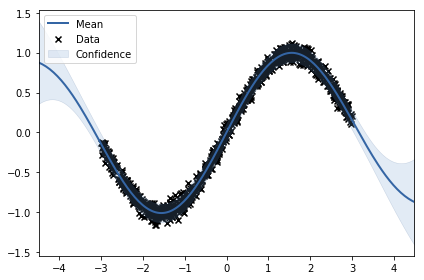

In [14]:
start = time.time()
model = GPy.models.GPRegression(X,y,kernel)
model.optimize()
time_gp = time.time()-start
model.plot()
plt.show()

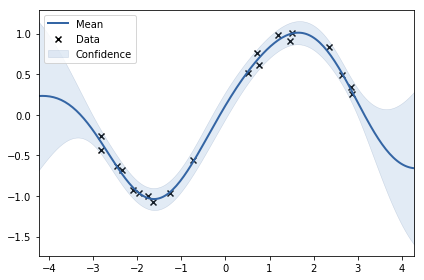

In [15]:
start = time.time()
model = GPy.models.GPRegression(X[ind],y[ind],kernel)
model.optimize()
time_sgp = time.time()-start
model.plot()
plt.show()

In [16]:
#improvement in time is:
print('reduce data by factor of 50, improve evaluation time by: time_gp / time_sgp = %2.1f'%(time_gp / time_sgp))

reduce data by factor of 50, improve evaluation time by: time_gp / time_sgp = 151.1
